Построить обобщенную линейную модель (GLM) для прогнозирования наступления страховых случаев на рассмотренных в ноутбуке данных. Придумать и использовать дополнительные факторы при построении модели (например, пересечения признаков и т.д.). Оценить результаты построенной модели при помощи различных метрик (можно использовать и другие метрики помимо представленных в ноутбуке), выявить проблемы. Попробовать улучшить результат и предложить способы решения обнаруженных проблем.

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     
import itertools
import warnings
warnings.simplefilter('ignore')

In [19]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,7 mins 48 secs
H2O cluster timezone:,Asia/Irkutsk
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_vitto_5n2rk8
H2O cluster total nodes:,1
H2O cluster free memory:,89.0 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [20]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int64
RecordBeg            115155 non-null object
RecordEnd            59455 non-null object
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int64
HasKmLimit           115155 non-null int64
BonusMalus           115155 non-null int64
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int64
ClaimNbResp          115155 non-null float64
ClaimNbNonResp       115155 non-null float64
ClaimNbParking       115155 non-null float64
ClaimNbFireTheft     115155 non-null float64
ClaimNbWindscreen    115155 non-null float64
OutUseNb             115155 non-null float64
RiskArea             115155 non-null float64
dtypes

In [21]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [22]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [23]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [24]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [25]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [26]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [27]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [28]:
df['SocioCateg'].unique()

array(['CSP50', 'CSP55', 'CSP60', 'CSP48', 'CSP6', 'CSP66', 'CSP1',
       'CSP46', 'CSP21', 'CSP47', 'CSP42', 'CSP37', 'CSP22', 'CSP3',
       'CSP49', 'CSP20', 'CSP2', 'CSP40', 'CSP7', 'CSP26', 'CSP65',
       'CSP41', 'CSP17', 'CSP57', 'CSP56', 'CSP38', 'CSP51', 'CSP59',
       'CSP30', 'CSP44', 'CSP61', 'CSP63', 'CSP45', 'CSP16', 'CSP43',
       'CSP39', 'CSP5', 'CSP32', 'CSP35', 'CSP73', 'CSP62', 'CSP52',
       'CSP27', 'CSP24', 'CSP19', 'CSP70'], dtype=object)

In [29]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [30]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [31]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [32]:
df = df.select_dtypes(exclude=['object'])

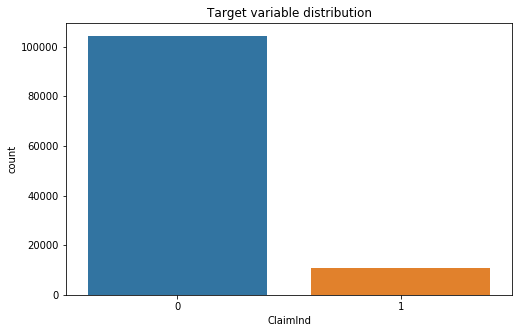

In [36]:
plt.figure(figsize=(8, 5))

sns.countplot(x='ClaimInd', data=df)

plt.title('Target variable distribution')
plt.show()

In [56]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [47]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df['DrivAgeTr'] = df.DrivAge.apply(lambda x: x**3)
df['DrivAgeL'] = df.DrivAge.apply(lambda x: np.log(x))
df['LicAgeY'] = df.LicAge.apply(lambda x: x/12)

In [48]:
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq,DrivAgeTr,DrivAgeL,LicAgeY
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,0,0,0,1,0,0,2116,97336,3.828641,27.666667
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,0,0,0,1,0,0,2116,97336,3.828641,27.750000
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,1,0,0,1024,32768,3.465736,14.416667
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,1,0,0,2704,140608,3.951244,30.333333
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,0,0,0,0,1,0,3249,185193,4.043051,35.500000


In [50]:
# Разбиение датасета на train/val/test

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df.drop(['ClaimInd', 'ClaimAmount'], axis=1), df.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_train_ind, y_train_ind, test_size=0.5, random_state=1)

In [57]:
df_for_balancing = pd.concat([x_train_ind, y_train_ind], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'ClaimInd')
    
df_balanced['ClaimInd'].value_counts()

0    72973
1    68715
Name: ClaimInd, dtype: int64

In [58]:
# Преобразование в H2O-Frame
h2o_train_ind = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_test_ind = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))
h2o_valid_ind = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [59]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных
h2o_test_ind['ClaimInd'] = h2o_test_ind['ClaimInd'].asfactor()
h2o_train_ind['ClaimInd'] = h2o_train_ind['ClaimInd'].asfactor()
h2o_valid_ind['ClaimInd'] = h2o_valid_ind['ClaimInd'].asfactor()

In [60]:
# Инициализируем и обучим GLM модель c кросс-валидацией
glm_binom = H2OGeneralizedLinearEstimator(family = "binomial", nfolds=5)
glm_binom.train(y="ClaimInd", x=h2o_train_ind.names[1:-1],
                training_frame=h2o_train_ind,
                validation_frame=h2o_valid_ind,
                weights_column = "Exposure")

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [61]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных
glm_binom.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 3.295E-5 )",28,27,3,py_1_sid_bf74


In [62]:
# Метрики качества модели - по всем данным и на кросс-валидации
glm_binom.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.51815414,0.08268849,0.44533113,0.58557147,0.43188912,0.5098702,0.61810905
1,auc,0.57884157,0.008395033,0.5706914,0.5836528,0.5868099,0.5842121,0.56884176
2,aucpr,0.16099769,0.004385196,0.15801741,0.16410616,0.15916677,0.16702463,0.15667348
3,err,0.48184583,0.08268849,0.55466884,0.41442856,0.5681109,0.49012986,0.38189098
4,err_count,3435.065,583.0305,3977.749,2960.482,4008.524,3504.995,2723.575
5,f0point5,0.18314122,0.0076555316,0.1750774,0.1939025,0.17723627,0.18735126,0.18213865
6,f1,0.24770996,0.007936896,0.24345969,0.25529435,0.24801834,0.25509906,0.23667839
7,f2,0.38468677,0.029820804,0.39949623,0.37357154,0.41292724,0.39959666,0.3378421
8,lift_top_group,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,logloss,0.37902346,0.004933877,0.37919995,0.38487563,0.37427723,0.38284007,0.37392437


In [63]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)
glm_binom._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-5.052989e-01,-1.946444
1,LicAge,-8.945185e-05,-0.014266
2,Gender,2.112553e-02,0.010230
3,MariStat,-5.573181e-02,-0.019929
4,DrivAge,8.323002e-03,0.124576
5,HasKmLimit,-3.946767e-01,-0.122635
6,BonusMalus,4.989321e-03,0.075226
7,ClaimNbResp,5.010692e-02,0.026273
8,ClaimNbNonResp,1.343844e-01,0.079948
9,ClaimNbParking,1.753381e-01,0.051688


In [64]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации
pmodels = {}
pmodels['overall'] = glm_binom.coef_norm()
for x in range(len(glm_binom.cross_validation_models())):
    pmodels[x] = glm_binom.cross_validation_models()[x].coef_norm()
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
BonusMalus,0.07523,0.08362,0.07024,0.07247,0.06572,0.07195
ClaimNbFireTheft,0.01158,0.00867,0.01164,0.00822,0.01241,0.01635
ClaimNbNonResp,0.07995,0.08137,0.09470,0.07691,0.07099,0.07614
ClaimNbParking,0.05169,0.05216,0.05710,0.04966,0.04847,0.05086
ClaimNbResp,0.02627,0.02967,0.01613,0.02902,0.03581,0.02428
ClaimNbWindscreen,0.08547,0.07598,0.09170,0.08789,0.08069,0.09012
DrivAge,0.12458,0.03232,0.39752,0.36042,0.41586,0.32722
DrivAgeL,-0.19820,-0.10202,-0.43541,-0.39831,-0.47054,-0.34020
DrivAgeSq,0.11964,0.04162,0.29498,0.26249,0.30106,0.21980
DrivAgeTr,-0.08773,-0.01720,-0.29650,-0.27584,-0.28972,-0.25711


In [69]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок
ind_train_pred = glm_binom.predict(h2o_train_ind).as_data_frame()
ind_test_pred = glm_binom.predict(h2o_test_ind).as_data_frame()
ind_valid_pred = glm_binom.predict(h2o_valid_ind).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [72]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок

print(f'TRAIN\n accuracy: {accuracy_score(y_train_ind, ind_train_pred.predict)}' + \
      f'\n       f1: {f1_score(y_train_ind, ind_train_pred.predict)}\n')

print(f'TEST\n accuracy: {accuracy_score(y_test_ind, ind_test_pred.predict)}' + \
      f'\n       f1: {f1_score(y_test_ind, ind_test_pred.predict)}\n')

print(f'VALID\n accuracy: {accuracy_score(y_valid_ind, ind_valid_pred.predict)}' + \
      f'\n       f1: {f1_score(y_valid_ind, ind_valid_pred.predict)}\n')

TRAIN
 accuracy: 0.5333465660976578
       f1: 0.1931013771504569

TEST
 accuracy: 0.5317834458118301
       f1: 0.18914622094272332

VALID
 accuracy: 0.5349096863834855
       f1: 0.19704433497536944



Сильный дисбаланс классов.Из-за этого низкиая F1 мера. Для улуяшения ситуации была сделана балансировка. Картина улучшилась, но еще есть над чем поработать в этом напрвлении